## Himanshu, MDS202327

#### Importing Packages

In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler

from PIL import Image
from tempfile import TemporaryDirectory

import os, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Read and load the data

In [3]:
data_dir = "/content/drive/MyDrive/chicken-duck-data"

In [12]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


#### Visualize some of the images

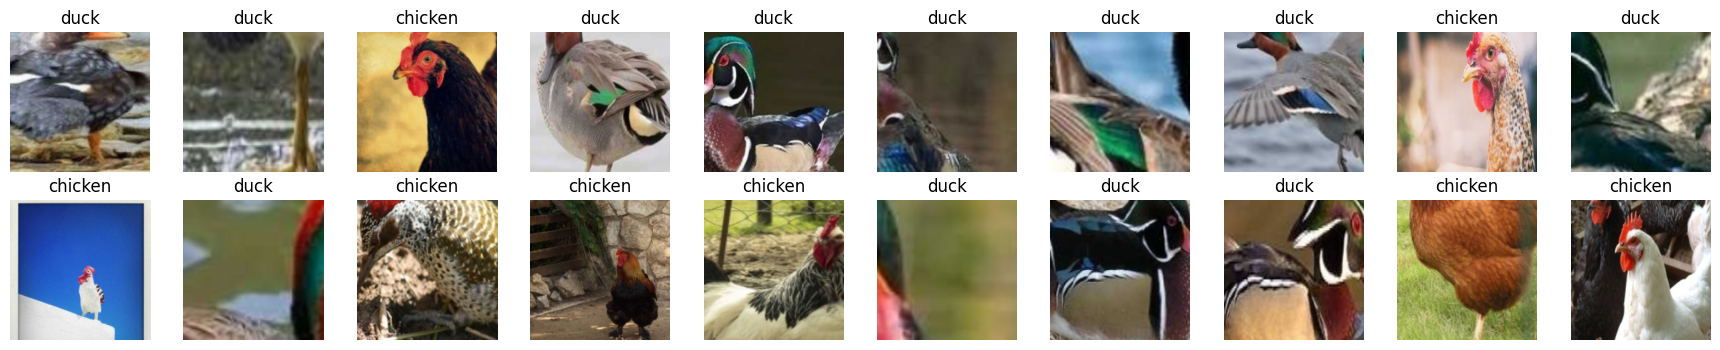

In [71]:
# show some training images

def imshow(inp, plot):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plot.imshow(inp)

plt.figure(figsize=(22, 4))

for j in range(5):
    # fetch a batch of train images; RANDOM
    image_batch, label_batch = next(iter(dataloaders['train']))

    for i in range(4):
        image = image_batch[i]
        label = label_batch[i].item()
        plt.subplot(2, 10, 4*(j) + i + 1)
        imshow(image,plt)
        plt.axis('off')
        if label == 0:
            plt.title('chicken')
        elif label == 1:
            plt.title('duck')

#### Functions for training and visualizing the prediction

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [67]:
def visualize_model(model, num_images=20):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(40, 7))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.axis('off')
                plt.subplot(2, 10, images_so_far)
                if labels[j].item() == 0:
                    plt.title(f'pred: {class_names[preds[j]]}; actual: chicken')
                elif labels[j].item() == 1:
                    plt.title(f'pred: {class_names[preds[j]]}; actual: duck')
                imshow(inputs.cpu().data[j], plt)

                if images_so_far == num_images:
                    plt.axis('off')
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### Model training

In [16]:
model_ft = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4189 Acc: 0.8699
val Loss: 0.1721 Acc: 0.9755

Epoch 1/24
----------
train Loss: 0.2261 Acc: 0.9155
val Loss: 0.0469 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.1852 Acc: 0.9307
val Loss: 0.0381 Acc: 0.9902

Epoch 3/24
----------
train Loss: 0.1709 Acc: 0.9324
val Loss: 0.0817 Acc: 0.9755

Epoch 4/24
----------
train Loss: 0.1604 Acc: 0.9527
val Loss: 0.0346 Acc: 0.9902

Epoch 5/24
----------
train Loss: 0.1334 Acc: 0.9476
val Loss: 0.0253 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.1185 Acc: 0.9595
val Loss: 0.0177 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0848 Acc: 0.9713
val Loss: 0.0352 Acc: 0.9902

Epoch 8/24
----------
train Loss: 0.1139 Acc: 0.9578
val Loss: 0.0220 Acc: 0.9951

Epoch 9/24
----------
train Loss: 0.0954 Acc: 0.9645
val Loss: 0.0189 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0663 Acc: 0.9780
val Loss: 0.0249 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1002 Acc: 0.9611
val Loss: 0.0152 Acc: 1.0000

Ep

#### Visualizing predictions

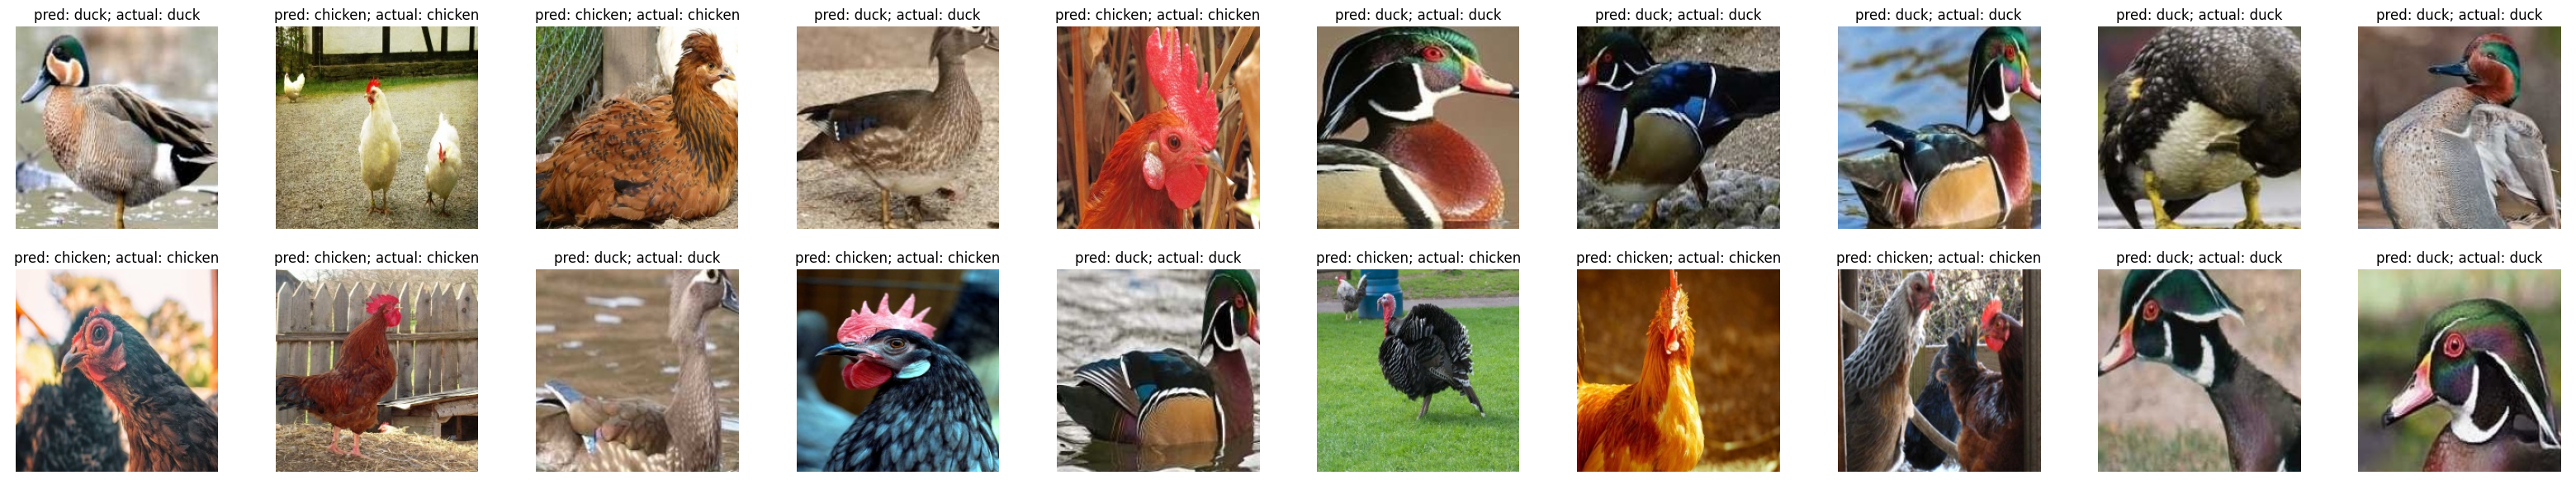

In [68]:
visualize_model(model_ft)